# Important Notes

For this assignment, you need to use Collaboratory. We are going to try to use the Hardware Accellerated option in Collaboratory. The computers at Nait are not set up for local work with GPUs (this requires a dedicated GPU to be installed and configured).

You will also need to make a kaggle profile if you do not have one yet. Go to www.kaggle.com and sign up. This will allow you to compete in competitions, get datasets, and use their API.

To use a GPU, go to "Runtime" and click on "Change runtime type" in Collaboratory. From there, you can select Python3 and GPU. If a GPU is not available now, continue with the exercise in a non-hardware accelerated backed and switch to a GPU one later. The GPU is only important when actually running the training code.


# Downloading the Data Directly from Kaggle

For this task, we will be classifying chest xrays. Take a look at the dataset decription on kaggle:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/data

We will be grabbing the data directly from kaggle. In order to do this you need to set up an API key on kaggle and put the key in your google drive.

Go to "My Account" on Kaggle. You can find this by clicking on your profile icon in the upper right hand corner of the site. Scroll down and find the API section. Click on the "Create New API Token" button and download the resulting file. Upload it to your google drive.

Then you can continue by running the code below:

In [ ]:
!pip install kaggle

In [1]:
# This authenticates with Kaggle using the api key you put in your google drive
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
# downloads the dataset

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:32<00:00, 30.5MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.7MB/s]


In [3]:
# unpacks it
import zipfile
with zipfile.ZipFile("chest-xray-pneumonia.zip") as z:
    z.extractall('.')

In [4]:
!ls

adc.json  chest_xray  chest-xray-pneumonia.zip	sample_data


# Reading the Data

The next thing we need to do is read the data into our python program. Each image will be represented by a numpy array. 

Run the following code to read the images as arrays. They will be stored as 224x224x3 matrices. The 3 color dimensions are RGB. The images are originally in greyscale, but the network structures we will use were designed with colour in mind.

After this code is ran you will have 6 lists. "normal" vs "pneumonia" refers to the class label. Normal is considered healthy and Pneumonia refers to any of the pneumonia types in the dataset. "train", "test", and "val" refer to the training, testing, and validation sets respectively. The validation set is small part of the training set that is kept aside for "early stopping". Early stopping is when we use a validation dataset to determine how many epochs is enough during the training phase.

In [ ]:
import os
from skimage.io import imread, imshow
import scipy
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def read_images(image_dir, input_size):
    images = []
    image_filenames = []
    for image_filename in os.listdir(image_dir):
        if ".jpeg" in image_filename:
            image_filenames.append(image_filename)
            image_array = cv2.imread(image_dir + image_filename, cv2.IMREAD_COLOR)
            image_array_resized = cv2.resize(image_array, (input_size, input_size))
            images.append(np.array(image_array_resized))
    return images, image_filenames

train_normal, train_normal_fnames = read_images("./chest_xray/train/NORMAL/", 224)
train_pneumonia, train_pneumonia_fnames = read_images("./chest_xray/train/PNEUMONIA/", 224)
val_normal, val_normal_fnames = read_images("./chest_xray/val/NORMAL/", 224)
val_pneumonia, val_pneumonia_fnames = read_images("./chest_xray/val/PNEUMONIA/", 224)
test_normal, test_normal_fnames = read_images("./chest_xray/test/NORMAL/", 224)
test_pneumonia, test_pneumonia_fnames = read_images("./chest_xray/test/PNEUMONIA/", 224)

print("Train Normal Size:", len(train_normal))
print("Train Pneumonia Size:", len(train_pneumonia))
print("Val Normal Size:", len(val_normal))
print("Val Pneumonia Size:", len(val_pneumonia))
print("Test Normal Size:", len(test_normal))
print("Test Pneumonia Size:", len(test_pneumonia))


KeyboardInterrupt: ignored

Feel free to look at the images. Remember that you can use the plt.imshow() function to display a matrix as an image.

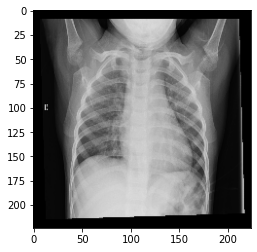

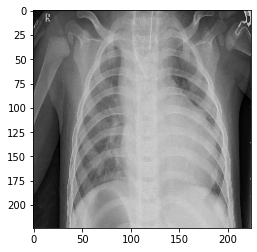

In [ ]:
# look at images here if you want

plt.subplots(0)
plt.imshow(train_normal[2])
plt.subplots(1)
plt.imshow(train_pneumonia[3])

Next lets combine our data classes and scramble them up. After running this chunk of code you will have train_labels, val_labels, and test_labels. These contain the class labels. 0 corresponds to normal and 1 corresponds to pneumonia.

This code also shuffles the datasets while keeping their order consistent with the labels.

Feel free to check the lengths of the various lists after this code chunk. Do not scramble their order any more though.

In [ ]:
# Combines the data
train_labels = [0 for x in range(len(train_normal))] + [1 for x in range(len(train_pneumonia))]
val_labels = [0 for x in range(len(val_normal))] + [1 for x in range(len(val_pneumonia))]
test_labels = [0 for x in range(len(test_normal))] + [1 for x in range(len(test_pneumonia))]

train_images = train_normal + train_pneumonia
val_images = val_normal + val_pneumonia
test_images = test_normal + test_pneumonia

# scrambles the data
train_permutation = np.random.permutation(len(train_images))

train_images = np.array(train_images)
train_images = train_images[train_permutation]

train_labels = np.array(train_labels)
train_labels = train_labels[train_permutation]

In [ ]:
len(train_labels)

5216

# Initializing the Keras Backend

Keras is a library that uses Tensorflow to do the backpropogation and for the network structures:

https://keras.io/

Have a look at the sequential section because that is what is important for this task.

Run the following code to import functions from Keras as well as initialize Keras with the GPU. You will have to be using the GPU hardware accelerated backed for Keras to connect to a GPU. If you are in a standard backend Keras will run on a CPU which is most likely be way to slow for this task.

You should get the message "Using Tensorflow Backend" after running this code.

In [ ]:
import random
import numpy as np
random.seed(1337)
np.random.seed(1337)

from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam, Adadelta
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras import regularizers
from keras import metrics
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

# Preprocessing

Load this function. This preprocesses the images so that they work with ImageNet weights. In the following code, I have already applied this function to the training data, but you will need to apply it to the test data so that the network gets input similar to what it was trained on.

In [ ]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    Borrowed from https://nbviewer.jupyter.org/gist/embanner/6149bba89c174af3bfd69537b72bca74
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


# Your Task

### Sub-Tasks


1) Choose your optimizer

https://keras.io/optimizers/

I have left out the optimizer declaration in the code I supplied.

2) Predict on the test data

Keras models have a predict method just like in sklearn. Predict on the test data and evaluate it just like we did in the sklearn exercises.

### Optional Goals

If you have accomplished the Sub-Tasks you can focus on making your model as accurate as possible. Often times that extra few percentage points will require a lot of creativity and extra fiddling.

Things you can add:

1) Early Stopping - Look up Callbacks in the Keras docs and add Early Stopping to your optimization. This will require using the validation set as well.

2) Save Best Model - Also a Callback. Save the best model weights and use those after iteration.

3) Try different optimizers.

4) Try different learning rates and observe the your optimization.

### If GPUs are unavailable

If GPUs can not be accessed, you can still use VGG16 to generate features. There is an example of this in Keras:

https://keras.io/applications/

The idea is you use the model.predict() method on you data to transform it from images to VGG features. Then you can train and test with any of the other classifiers we have learned so far.

You will have to design your own experiment for that as the optimization code I supply is meant for fine-tuning. You can use the variables (test, train etc.) we have loaded already.


In [ ]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    Borrowed from https://nbviewer.jupyter.org/gist/embanner/6149bba89c174af3bfd69537b72bca74
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


INPUT_SIZE = 224
def VGG_16_for_classification_fine_tuning():
    """
    VGG_16 for transfer learning
    This is the model from Keras with imagenet weights
    I added a fully connected dense set of layers with drop out
    Everything is regularized with smaller regularization on the top 3 layers
    of the VGG model. Those layers are also left trainable for fine-tuning.
    This method returns the model object.
    """
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

    last = base_model.output
    x = GlobalAveragePooling2D()(last)
    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.5), kernel_initializer='he_uniform')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.5), kernel_initializer='he_uniform')(x)
    x = Dropout(0.5)(x)
    preds_layer = Dense(2, activation='softmax', kernel_initializer='he_uniform')(x)

    model = Model(base_model.input, preds_layer)

    for layer in model.layers[:15]:
        layer.trainable = False
    for layer in model.layers[15:]:
        layer.trainable = True

    model.layers[15].kernel_regularizer = regularizers.l2(0.01)
    model.layers[16].kernel_regularizer = regularizers.l2(0.01)
    model.layers[17].kernel_regularizer = regularizers.l2(0.01)

    return model


The experiment code to run the function is below:

In [ ]:
number_of_epochs = 5
from tensorflow import keras
from tensorflow.keras import layers

# prepare the training and validation data
x_train = np.array(train_images)
y_train = to_categorical(train_labels, num_classes=2)
x_val = np.array(val_images)
y_val = to_categorical(val_labels, num_classes=2)

data_gen_args = dict(preprocessing_function=preprocess_input_vgg)
train_image_datagen = ImageDataGenerator(**data_gen_args)


# augmentation seed fixed
seed = 1
train_image_generator = train_image_datagen.flow(
    x_train,
    y_train,
    seed=seed,
    batch_size=32)

model = VGG_16_for_classification_fine_tuning()

# you will have to declare the my_optimizer variable
# You can decide what optimizer to use

opt = keras.optimizers.Adam(learning_rate=0.0001)

# https://keras.io/optimizers/
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=[metrics.categorical_crossentropy, metrics.binary_accuracy])

history = model.fit_generator(train_image_generator,
                              steps_per_epoch=len(x_train) // 32,
                              epochs=number_of_epochs,
                              verbose=1)

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
163/163 [==============================] - 88s 287ms/step - loss: 6772.9941 - categorical_crossentropy: 0.9356 - binary_accuracy: 0.7850
Epoch 2/5
163/163 [==============================] - 48s 292ms/step - loss: 3071.3370 - categorical_crossentropy: 0.0535 - binary_accuracy: 0.9784
Epoch 3/5
163/163 [==============================] - 48s 292ms/step - loss: 1567.1733 - categorical_crossentropy: 0.0459 - binary_accuracy: 0.9835
Epoch 4/5
163/163 [==============================] - 48s 291ms/step - loss: 869.1296 - categorical_crossentropy: 0.0361 - binary_accuracy: 0.9858
Epoch 5/5
163/163 [==============================] - 48s 292ms/step - loss: 491.6305 - categorical_crossentropy: 0.0244 - binary_accuracy: 0.9921


In [ ]:
# after training, predict on test data and report some accuracy metrics



# Note: training takes a long time. If you want to test your prediction code,
# set the number of training epochs to a small number and then testing the
# prediction code. After you are sure it works, then increase the number of epochs
test_images_processed = np.copy(np.array(test_images))
test_images_processed = test_images_processed.astype('float32')

test_ab = np.array(preprocess_input_vgg(test_images_processed))

In [ ]:
VGG_preds = model.predict(test_ab)

In [ ]:
VGG_preds

array([[8.2589922e-06, 9.9999177e-01],
       [9.9527246e-01, 4.7275592e-03],
       [9.0748286e-01, 9.2517167e-02],
       ...,
       [4.9380815e-06, 9.9999511e-01],
       [1.1562807e-03, 9.9884367e-01],
       [7.8808171e-07, 9.9999917e-01]], dtype=float32)

In [ ]:
pred_list = []
for each in VGG_preds:
  if each[1]>0.5:
    pred_list.append(1)
  else:
    pred_list.append(0)

In [ ]:
pred_list.count(0)

135

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [ ]:
test_labels.count(0)

234

In [ ]:
 print(f"The accuracy score of the MLP Classifier is: {accuracy_score(test_labels,pred_list)}")
print(f"The precision score of the MLP Classifier is: {precision_score(test_labels,pred_list)}")
print(f"The recall score of the MLP Classifier is: {recall_score(test_labels,pred_list)} \n \n")

print(classification_report(test_labels,pred_list))

The accuracy score of the MLP Classifier is: 0.8285256410256411
The precision score of the MLP Classifier is: 0.7893660531697342
The recall score of the MLP Classifier is: 0.9897435897435898 
 

              precision    recall  f1-score   support

           0       0.97      0.56      0.71       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.83      0.82       624

